# Web Scraping with BeautifulSoup
As a data analyst, the ability to scrape data from the web is a crucial skill. In this project, I used web scraping to gather data from Jumia which is a leding E-commerce platform in East Africa. My goal was to extract and compile a list of all products offered at a discount as of October 10th, 2024.
* Lets start by importing the necessary libraries

In [1]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

* Now lets begin scraping

In [2]:
#defining our url
url ="https://www.jumia.co.ke/mlp-top-deals/"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36",
    "Accept-Language": "en-GB,en-US;q=0.9,en;q=0.8"
}

#lets create an empyty list that will store the products
all_products = []
#we'll iterate the 50 pages of the website
for page in range(1, 51):
    next_url = f"{url}?page={page}"
    response = requests.get(next_url, headers=headers)
    
    if response.status_code == 200:
        soup = bs(response.text, "html.parser")
        
        #finding all product containers
        products = soup.find_all("div", class_="info")
        
        #extracting the details details
        for product in products:
            name = product.find("h3", class_="name").get_text(strip=True)
            price = product.find("div", class_="prc").get_text(strip=True)
            old_price = product.find("div", class_="old")
            discount = product.find("div", class_="bdg _dsct _sm")
            rating = product.find("div", class_="stars _s")
            items_left = product.find("div", class_="stk")
            
            #extract text and set as None if not available
            old_price = old_price.get_text(strip=True) if old_price else None
            discount = discount.get_text(strip=True) if discount else None
            rating = rating.get_text(strip=True) if rating else None
            items_left = items_left.get_text(strip=True) if items_left else None
            
            #lets store the product details in a dictionary
            product_info = {
                "Name": name,
                "Price": price,
                "Old Price": old_price,
                "Discount": discount,
                "Rating": rating,
                "Items Left": items_left
            }
            
            #appending our product info to the list
            all_products.append(product_info)
    else:
        print(f"Failed to retrieve page {page}: {response.status_code}")

* Its always much easier to work with a dataframe, so we'll create a dataframe from the list we have appended our products and save the dataframe

In [3]:
df = pd.DataFrame(all_products)
df.to_csv(r"C:\Users\USER\Desktop\Scraping\Jumia_Deals.csv", index=False)

### Exploratory Data Analysis

In [4]:
#importing our data
df=pd.read_csv("Jumia_Deals.csv")
display(df.head())

,Name,Price,Old Price,Discount,Rating,Items Left
0,4 Speeds Mini Electric Muscle Massage Gun For ...,KSh 622,"KSh 1,000",38%,4.2 out of 5,NaN
1,Portable Mini Bluetooth Pocket Thermal Printer,"KSh 2,318","KSh 3,520",34%,4.5 out of 5,NaN
2,Women Elegant Fashion High Appearance Level Zi...,"KSh 1,785","KSh 2,200",19%,4 out of 5,NaN
3,Plug And Play High Performance Power Upgrade O...,KSh 161,KSh 206,22%,3.5 out of 5,NaN
4,Black License Plate Frame Camera Vehicle Back ...,"KSh 1,035","KSh 1,400",26%,3.5 out of 5,NaN


* Lets see if our data set is clean

In [5]:
print(df.dtypes)

Name           object
Price          object
Old Price      object
Discount       object
Rating         object
Items Left    float64
dtype: object


In [6]:
print(df.isna().sum())

Name             0
Price            0
Old Price      158
Discount       158
Rating         268
Items Left    2000
dtype: int64


* The Items left column seems to be completely empty, so we'll drop it as well as the other missing values

In [7]:
df.drop(columns="Items Left",inplace=True)
df.dropna(subset=["Old Price","Discount","Rating"],inplace=True)
print(df.isna().sum())

Name         0
Price        0
Old Price    0
Discount     0
Rating       0
dtype: int64


* Lets do some cleaning our data

In [8]:
#lets remove the non digits from the Price, Old Price and Discount columns and turn them to intergers
columns=["Price","Old Price","Discount"]
for col in columns:
    df[col]=df[col].str.replace(r"[^\d]","", regex=True)
    df[col]=df[col].astype(int)

df["Rating"] =df["Rating"].str.replace("out of 5","").astype(float)
df["Name"] =df["Name"].str.strip().str.replace("'","")
print(df.dtypes)

Name          object
Price          int32
Old Price      int32
Discount       int32
Rating       float64
dtype: object


Now that our dataset is clean lets try and see if we can categorize the names of the products into five categories namely;
* Clothings
* Gadgets
* Electronics
* Footwear
* Others

We'll use the regex pattern method as it leverages regex to match any substring making it easy to deal with the variations.

In [9]:
#lets define our regex patterbs
clothings_pattern = r"(?:clothes|dress|shirt|t-shirt|underwear|pants|suit|earrings|boxer|sweater|belt|short|bag|dresses)"
gadgets_pattern = r"(?:bluetooth|wireless|mobile|plug|smartwatch|headphone|watch|usb|power|camera|wrist|bank|speaker)"
electronics_pattern = r"(?:electric|tv|toaster|ramtons|machine|maker)"
footwear_pattern = r"(?:shoe|shoes|sneakers)"

# Use `str.contains()` to create a new column for the category
df["Category"] = (
    df["Name"].str.lower()
    .apply(lambda x: 
        "Clothings" if pd.Series(x).str.contains(clothings_pattern, regex=True).any() else
        "Gadgets" if pd.Series(x).str.contains(gadgets_pattern, regex=True).any() else
        "Electronics" if pd.Series(x).str.contains(electronics_pattern, regex=True).any() else
        "Footwear" if pd.Series(x).str.contains(footwear_pattern, regex=True).any() else
        "Others"
    )
)

In [10]:
#lets check out our new column
display(df.head())
print(df["Category"].value_counts())

,Name,Price,Old Price,Discount,Rating,Category
0,4 Speeds Mini Electric Muscle Massage Gun For ...,622,1000,38,4.2,Electronics
1,Portable Mini Bluetooth Pocket Thermal Printer,2318,3520,34,4.5,Gadgets
2,Women Elegant Fashion High Appearance Level Zi...,1785,2200,19,4.0,Gadgets
3,Plug And Play High Performance Power Upgrade O...,161,206,22,3.5,Gadgets
4,Black License Plate Frame Camera Vehicle Back ...,1035,1400,26,3.5,Gadgets


Category
Others         551
Gadgets        389
Clothings      341
Footwear       232
Electronics     85
Name: count, dtype: int64


### Data Visualizations

#### Category Breakdown
Count of products in each Category

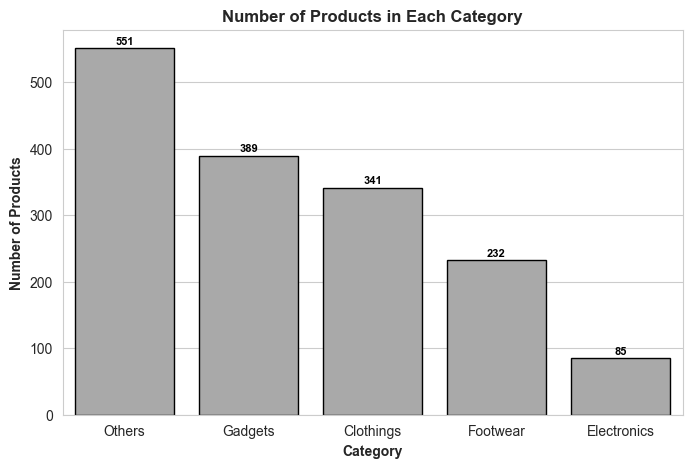

In [11]:
count=df["Category"].value_counts(ascending=False)
order =count.index
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
ax=sns.countplot(data=df, x="Category", order=order,color="darkgray",edgecolor="black")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", 
                va="baseline", 
                fontsize=8,
                fontweight="bold",
                color="black", 
                xytext=(0, 3),
                textcoords="offset points")
plt.title("Number of Products in Each Category",fontweight="bold")
plt.xlabel("Category",fontweight="bold")
plt.ylabel("Number of Products",fontweight="bold")
plt.show()

#### Price Analysis
* Lets do a price analysis by getting the price reduction across all the categories

In [12]:
df["Price Drop"] =df["Old Price"] -df["Price"]
avg_price =df.groupby("Category")[["Price","Old Price","Price Drop"]].mean().reset_index()
display(avg_price)

,Category,Price,Old Price,Price Drop
0,Clothings,1.931253e+05,6.505409e+05,457415.615836
1,Electronics,7.554129e+03,9.679106e+03,2124.976471
2,Footwear,1.169820e+06,1.940804e+06,770983.939655
3,Gadgets,3.445730e+03,1.795299e+04,14507.264781
4,Others,5.442413e+04,1.115751e+05,57150.990926


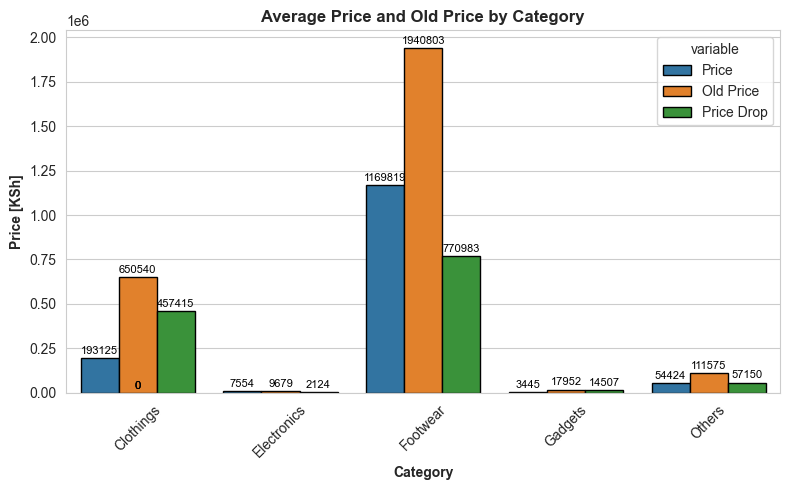

In [13]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=avg_price.melt(id_vars="Category"), x="Category", y="value", hue="variable",edgecolor="black")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", 
                va="baseline", 
                fontsize=8, 
                color="black", 
                xytext=(0, 3),
                textcoords="offset points")
plt.title("Average Price and Old Price by Category", fontweight="bold")
plt.ylabel("Price [KSh]",fontweight="bold")
plt.xlabel("Category",fontweight="bold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Discount Analysis
* Lets look at the average discount offered in each Category to see where the biggest price drops occur.

In [14]:
discount_analysis = df.groupby("Category")["Discount"].mean().reset_index().sort_values(by="Discount", ascending=False)
display(discount_analysis)

,Category,Discount
2,Footwear,40.051724
0,Clothings,38.741935
3,Gadgets,38.095116
4,Others,37.760436
1,Electronics,29.705882


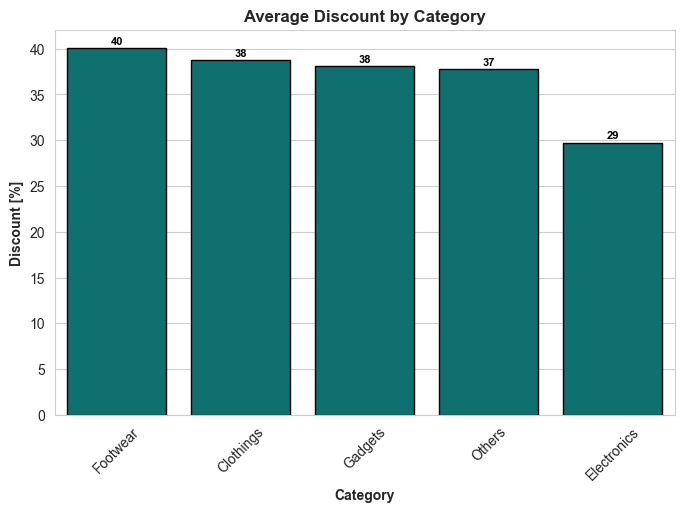

In [15]:
plt.figure(figsize=(8, 5))
ax=sns.barplot(data=discount_analysis, x="Category", y="Discount", color ="teal", edgecolor="black")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", 
                va="baseline", 
                fontsize=8, 
                fontweight="bold",
                color="black", 
                xytext=(0, 3),
                textcoords="offset points")
plt.title("Average Discount by Category",fontsize=12,fontweight="bold")
plt.ylabel("Discount [%]",fontweight="bold")
plt.xlabel("Category",fontweight="bold")
plt.xticks(rotation=45)
plt.show()

### Ratings Analysis
Analyze Average Rating per Category:

In [16]:
#lets calculate average rating for each category
ratings = df.groupby("Category")["Rating"].mean().reset_index().sort_values(by="Rating",ascending=False)
display(ratings)

,Category,Rating
4,Others,4.098548
1,Electronics,4.035294
3,Gadgets,3.950643
2,Footwear,3.862500
0,Clothings,3.780938


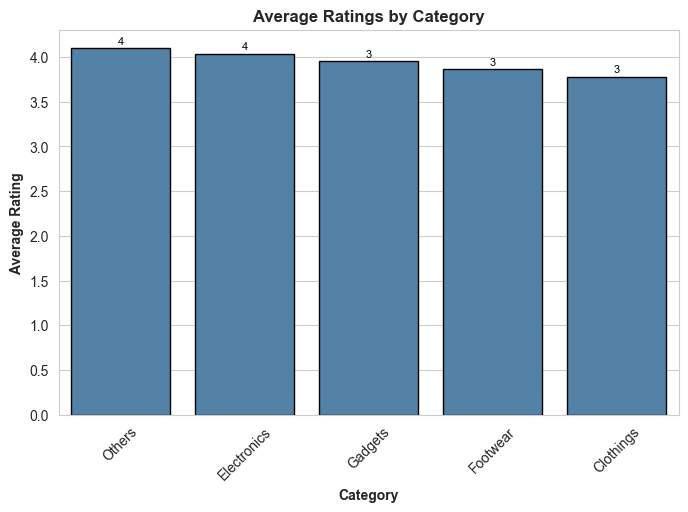

In [18]:
plt.figure(figsize=(8, 5))
ax=sns.barplot(data=ratings, x="Category", y="Rating", color="steelblue", edgecolor="black")
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha="center", 
                va="baseline", 
                fontsize=8, 
                color="black", 
                xytext=(0, 3),
                textcoords="offset points")
plt.title("Average Ratings by Category",fontweight="bold")
plt.xlabel("Category", fontweight="bold")
plt.ylabel("Average Rating",fontweight="bold")
plt.xticks(rotation=45)
plt.show()

* Lets see if higher discounts relate to better or worse reviews.

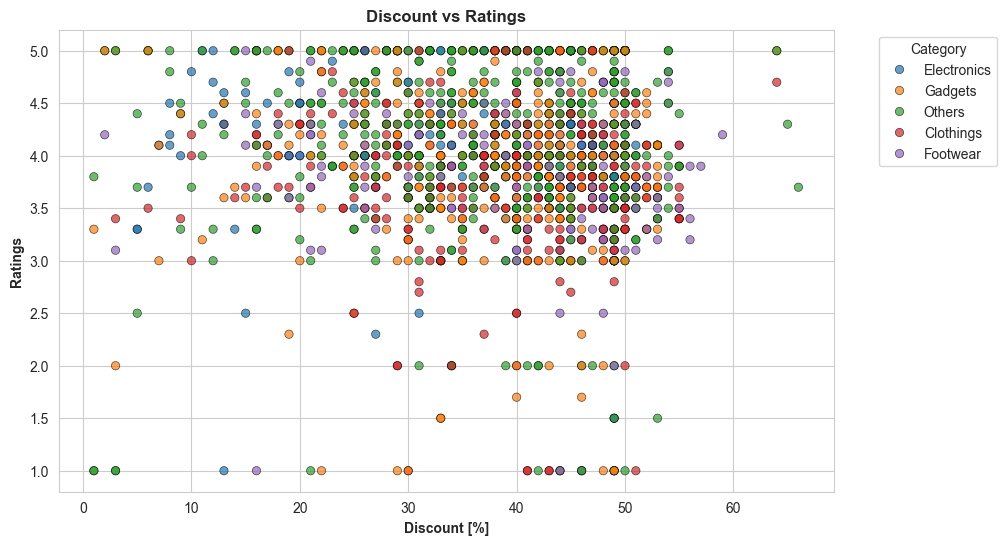

In [19]:
#scatter plot of discount vs ratings
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Discount", y="Rating", hue="Category", palette="tab10", alpha=0.7,edgecolor="black")
plt.title("Discount vs Ratings",fontweight="bold")
plt.xlabel("Discount [%]",fontweight="bold")
plt.ylabel("Ratings",fontweight="bold")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

* Lets create a word cloud of the most common products for each category to see popular terms.

In [20]:
#lets create a function to plot word cloud
def plot_wordcloud(category):
    text = " ".join(df[df['Category'] == category]['Name'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {category}')
    plt.show()

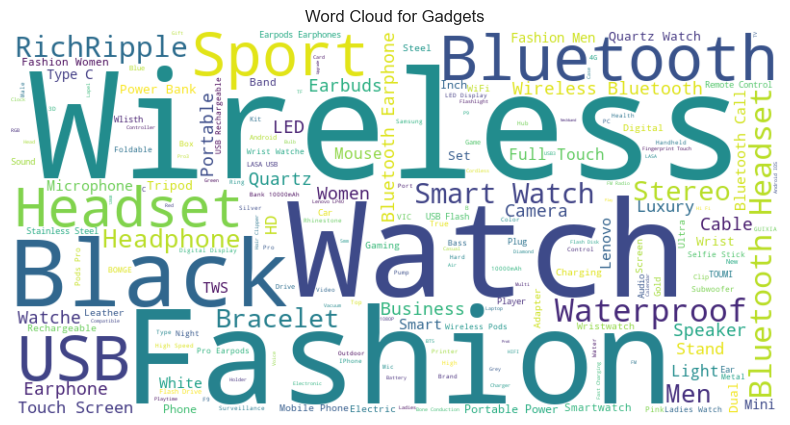

In [21]:
plot_wordcloud("Gadgets")

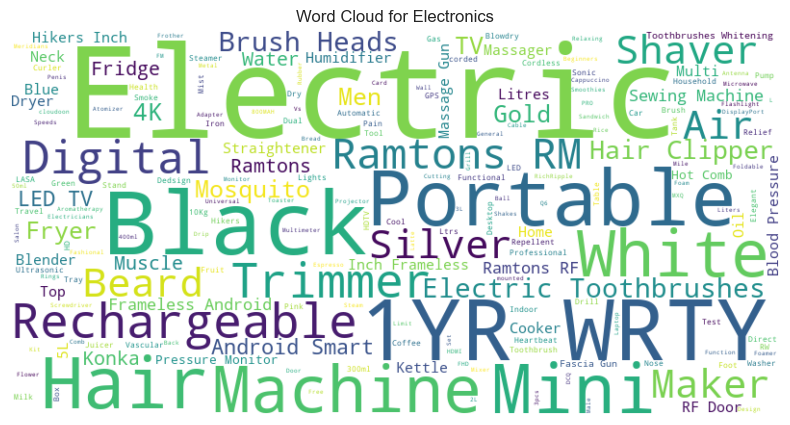

In [22]:
plot_wordcloud("Electronics")

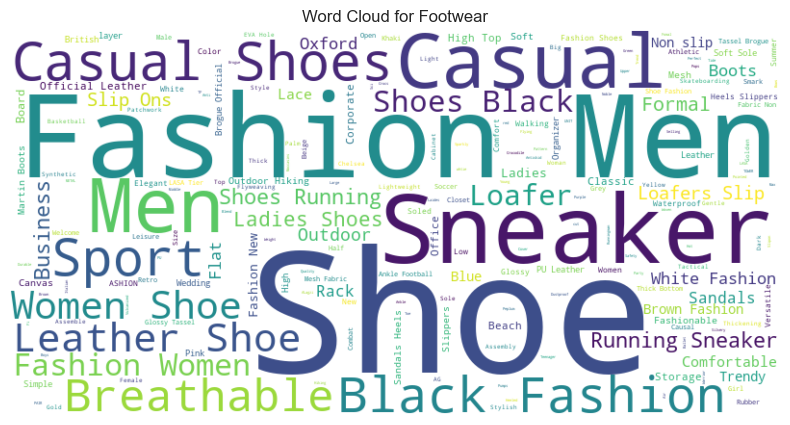

In [23]:
plot_wordcloud("Footwear")

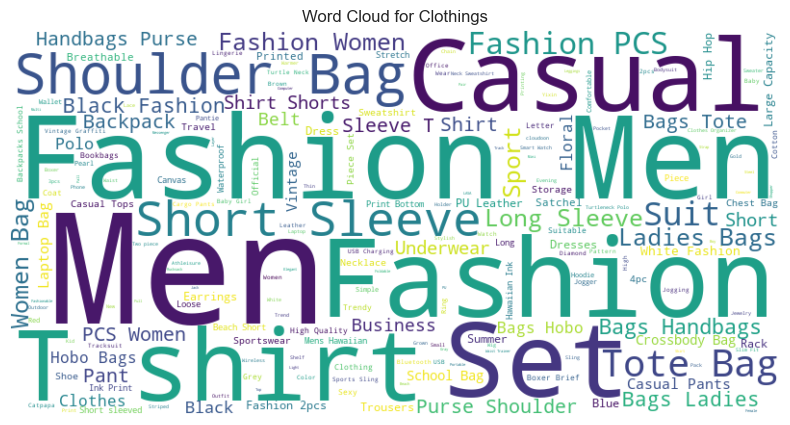

In [24]:
plot_wordcloud("Clothings")

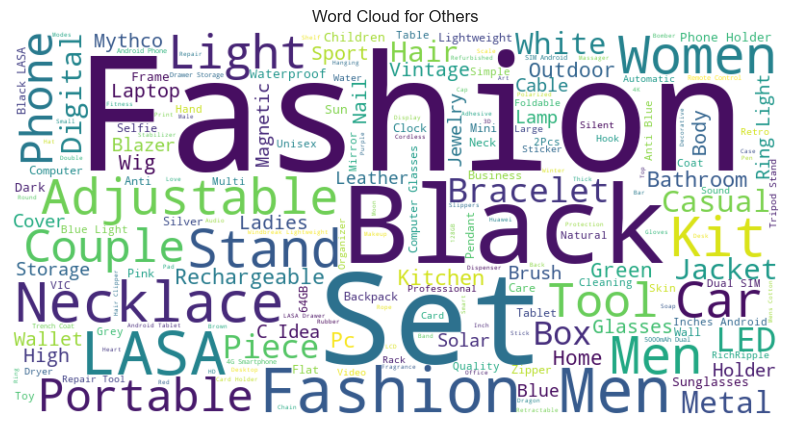

In [25]:
plot_wordcloud("Others")

### Conclusion
The analysis below provides insights into product categories, discounts and customer ratings.

* The majority of discounted products was the "Others" category (551), followed by Gadgets (369) and Clothings (341) while Electronics having the fewest items on discount (85).

* Footwear had highest average discount of 40%, suggesting a higher tendency for retailers offering deals in this category. Clothings and Gadgets also had relatively high discounts of (38%) while Electronics had the lowest average discount of 29%.

* The "Others" and "Electronics" categories had the highest average ratings of 4, indicating good customer satisfaction while Gadgets, Footwear, and Clothings all had an average rating of 3, indicating less customer satisfaction.

* Looking at the word clouds for Gadgets, terms like "Wireless" and "Bluetooth" were prominent. Electronics often featured "Electric" and "Portable." Footwear focused on "Shoe" and "Sneaker," while Clothings included terms like "Casual" and "Fashion."

The project demonstrates the power of web scraping and data analysis in extracting actionable insights from online data.